In [2]:
import sklearn 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_csv('GLCM_feature_ALL_sky_cloud.csv')
df

,Unnamed: 0,contrast,dissimilarity,homogeneity,energy,correlation,ASM,intensity
0,img_1.jpg,40.815418,1.360482,0.704443,0.215592,0.984059,0.046480,51.379677
1,img_2.jpg,35.784471,1.269493,0.728622,0.216493,0.985841,0.046869,54.899999
2,img_3.jpg,31.704978,1.092381,0.773062,0.218654,0.984265,0.047809,52.630197
3,img_4.jpg,27.822333,0.951884,0.801196,0.220864,0.984192,0.048781,50.193809
4,img_5.jpg,26.170514,0.910857,0.815979,0.221967,0.984512,0.049269,48.827294
...,...,...,...,...,...,...,...,...
519,img_520.jpg,27.021423,0.961375,0.791882,0.219756,0.982853,0.048293,46.132000
520,img_521.jpg,27.492694,0.981876,0.794016,0.219793,0.982552,0.048309,46.272434
521,img_522.jpg,27.733203,0.968336,0.805953,0.220709,0.982296,0.048713,46.240412
522,img_523.jpg,26.779714,0.947848,0.807715,0.222255,0.981787,0.049397,45.340688


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:122: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: ylabel='intensity'>

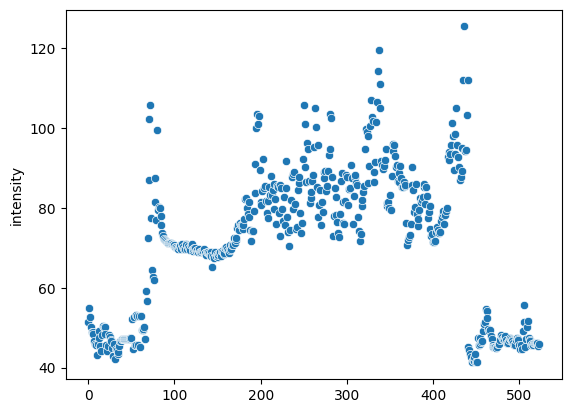

In [4]:
name_y = str('intensity')
name_x = np.arange(len(df))
sns.scatterplot(data=df,x=name_x,y=name_y,cmap='viridis')

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


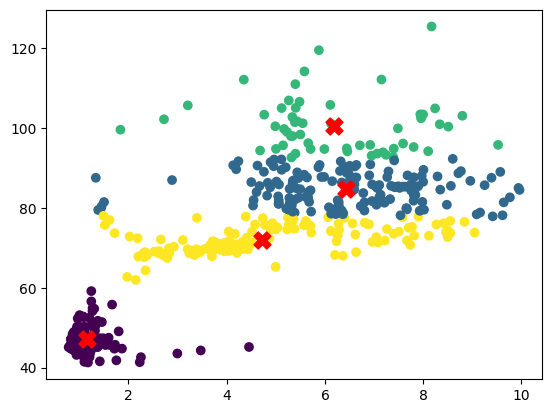

In [7]:
from sklearn.cluster import KMeans

x = list(df['dissimilarity'])
y = list(df[name_y])
dataset = list(zip(x,y))

kmeans = KMeans(n_clusters=4).fit(dataset)

plt.scatter(x, y, c=kmeans.labels_,cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='r',marker='X',s=150)

In [74]:
df

,Unnamed: 0,contrast,dissimilarity,homogeneity,energy,correlation,ASM,intensity
0,img_1.jpg,91.807942,1.502158,0.879787,0.743012,0.974725,0.552066,51.379677
1,img_2.jpg,57.872861,1.359396,0.802545,0.437784,0.983904,0.191655,54.899999
2,img_3.jpg,60.384937,1.256944,0.841142,0.412785,0.979245,0.170391,52.630197
3,img_4.jpg,76.320879,1.183216,0.902714,0.552011,0.971849,0.304716,50.193809
4,img_5.jpg,32.912637,0.966523,0.829950,0.263015,0.982617,0.069177,48.827294
...,...,...,...,...,...,...,...,...
519,img_520.jpg,41.493235,1.189740,0.800326,0.245403,0.975506,0.060223,46.132000
520,img_521.jpg,41.275372,1.178397,0.802421,0.238817,0.975257,0.057034,46.272434
521,img_522.jpg,43.158532,1.161160,0.816038,0.243392,0.974218,0.059240,46.240412
522,img_523.jpg,48.306455,1.211098,0.823475,0.255537,0.970140,0.065299,45.340688


<Axes: ylabel='correlation'>

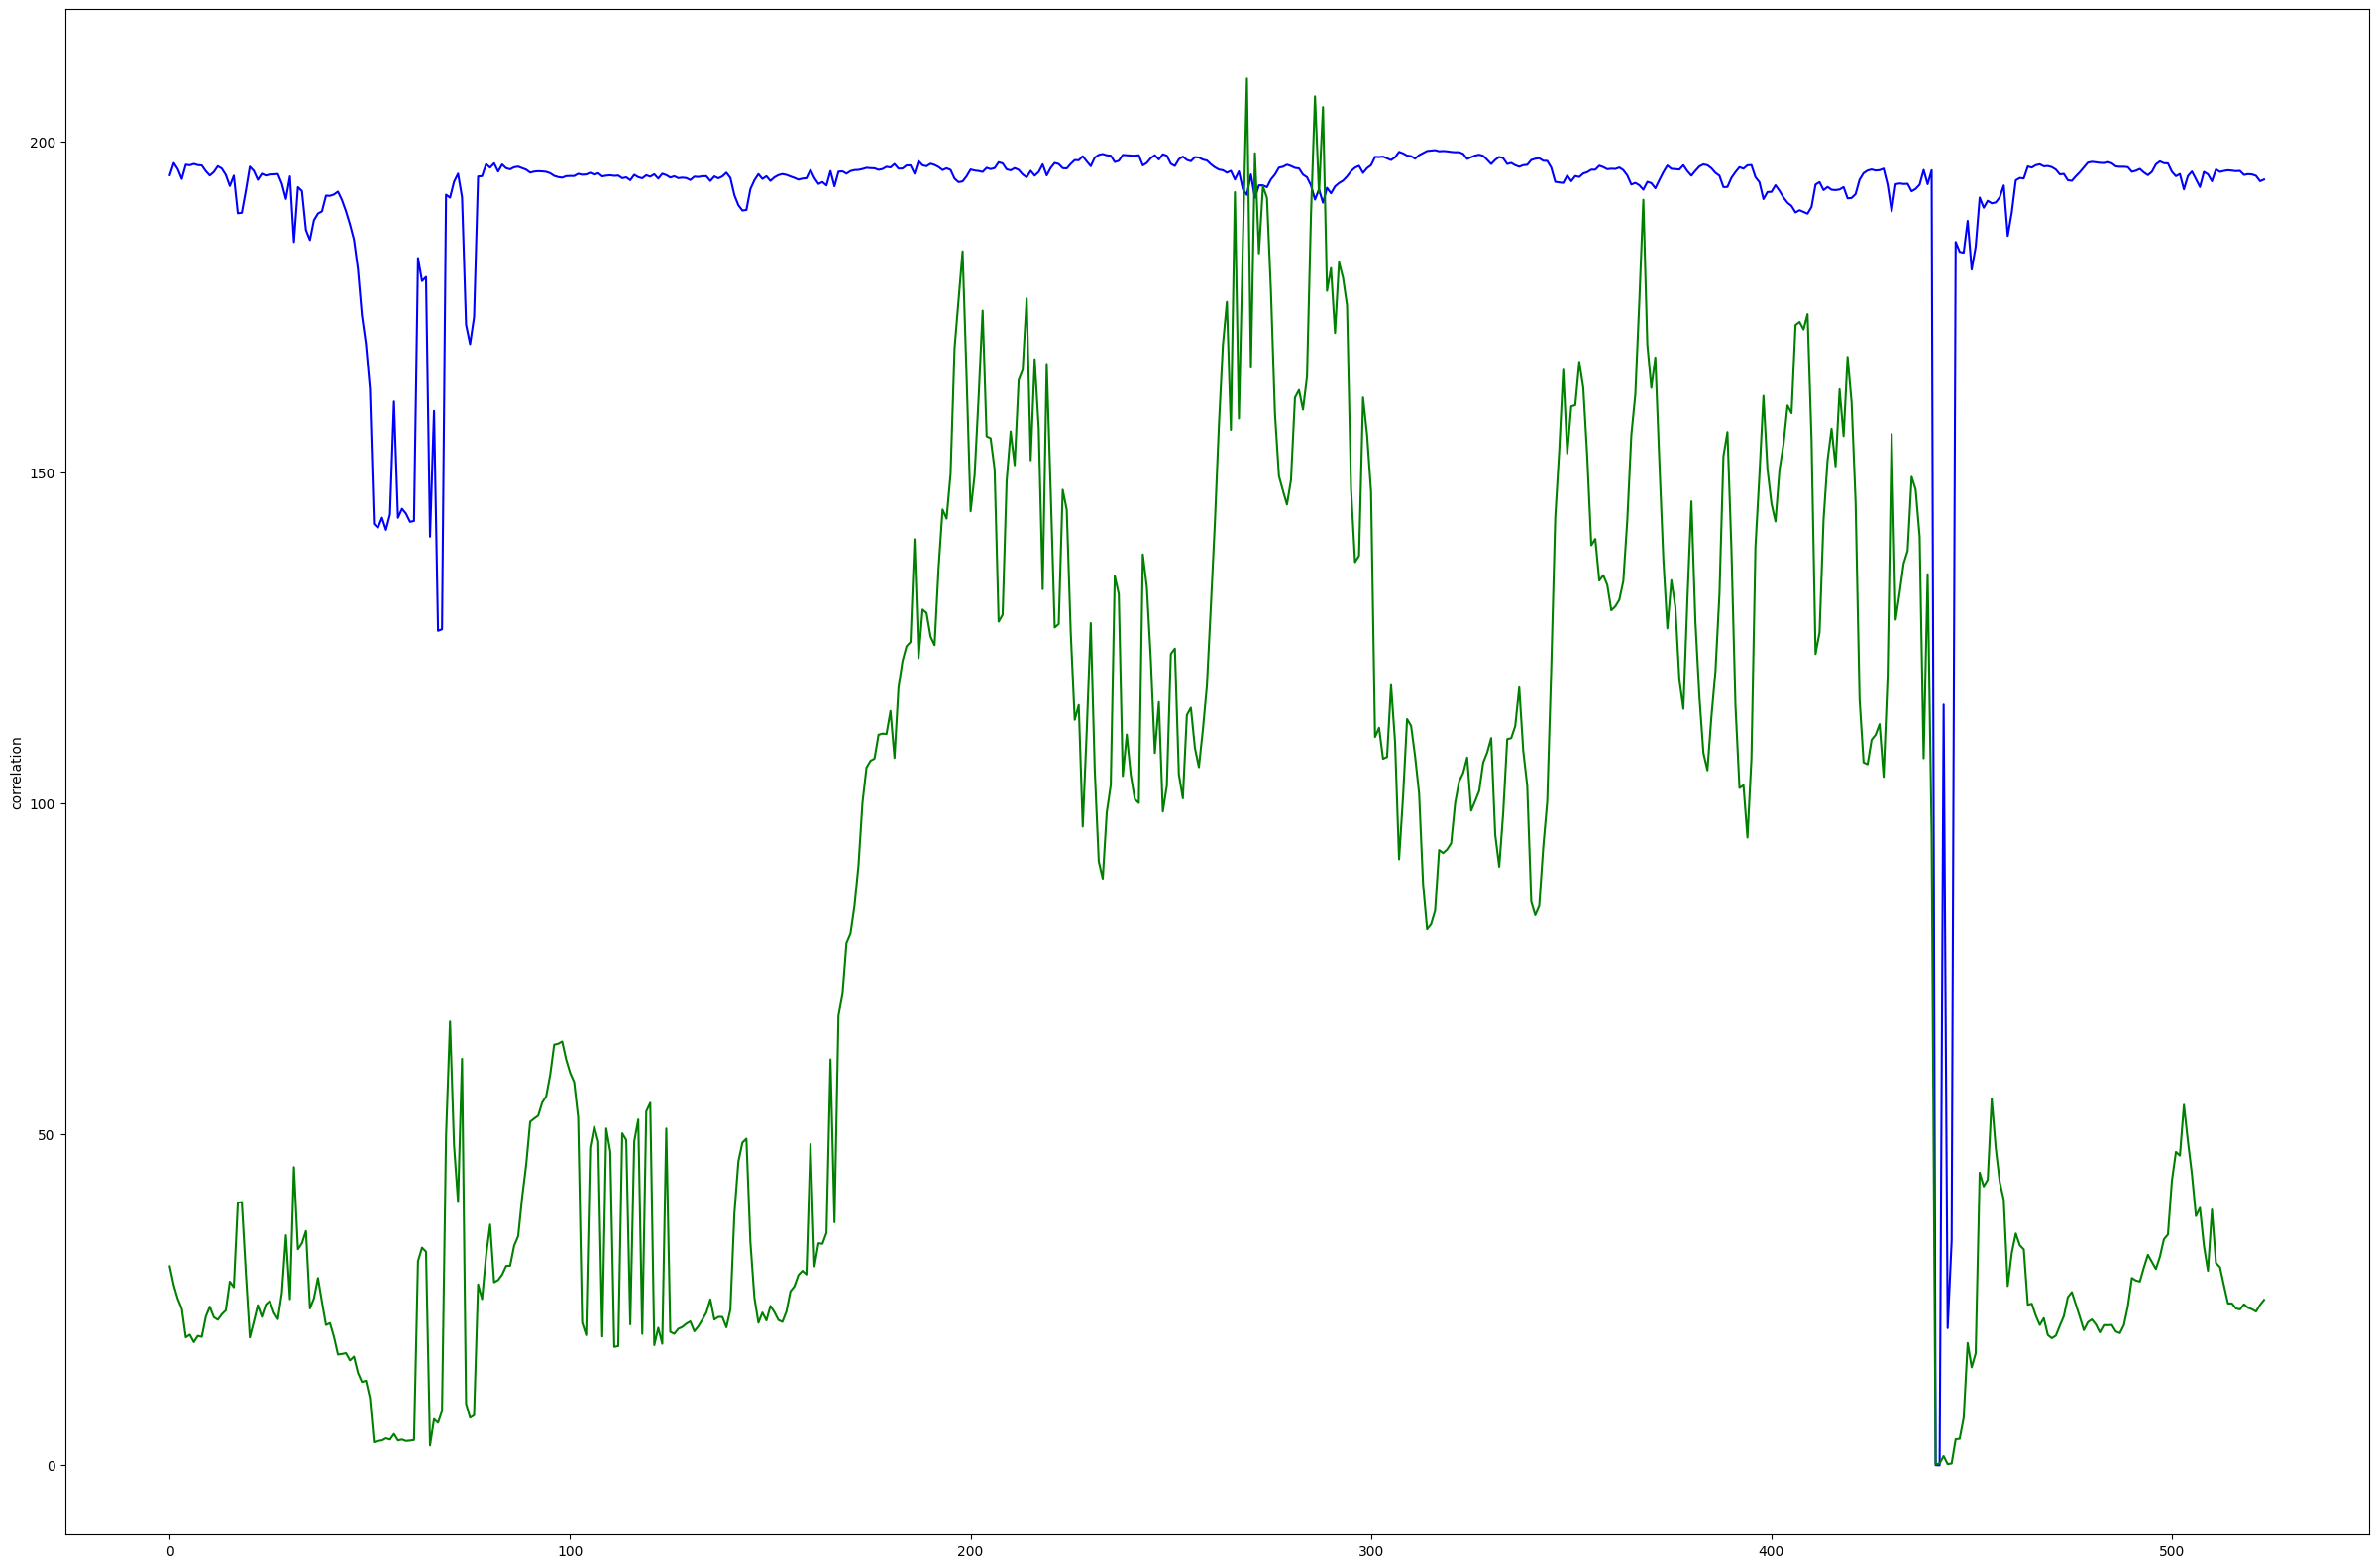

In [91]:
name_y = str('correlation')
name_x = np.arange(len(df))

plt.figure(figsize=(30,20))
sns.lineplot(data=df,x=name_x,y=df[name_y]*200,c='blue')
sns.lineplot(data=df,x=name_x,y=df['dissimilarity']*20,c='green')

In [76]:
import pickle
'''
with open('DayNight.pkl', 'wb') as f:
    pickle.dump(kmeans, f)'''

"\nwith open('DayNight.pkl', 'wb') as f:\n    pickle.dump(kmeans, f)"

In [77]:
with open('DayNight.pkl', 'rb') as f:
    model = pickle.load(f)

In [78]:
x_test = list(np.arange(len(df)))
y_test = list(df[name_y])
dataset_test = list(zip(x_test,y_test))

prediction = model.predict(dataset_test)

In [79]:
df['cluster'] = prediction
df['note'] = 'Day'  # Default value
df.loc[df['cluster'].isin([0, 3]), 'note'] = 'Night'

In [80]:
df

,Unnamed: 0,contrast,dissimilarity,homogeneity,energy,correlation,ASM,intensity,cluster,note
0,img_1.jpg,91.807942,1.502158,0.879787,0.743012,0.974725,0.552066,51.379677,0,Night
1,img_2.jpg,57.872861,1.359396,0.802545,0.437784,0.983904,0.191655,54.899999,0,Night
2,img_3.jpg,60.384937,1.256944,0.841142,0.412785,0.979245,0.170391,52.630197,0,Night
3,img_4.jpg,76.320879,1.183216,0.902714,0.552011,0.971849,0.304716,50.193809,0,Night
4,img_5.jpg,32.912637,0.966523,0.829950,0.263015,0.982617,0.069177,48.827294,0,Night
...,...,...,...,...,...,...,...,...,...,...
519,img_520.jpg,41.493235,1.189740,0.800326,0.245403,0.975506,0.060223,46.132000,3,Night
520,img_521.jpg,41.275372,1.178397,0.802421,0.238817,0.975257,0.057034,46.272434,3,Night
521,img_522.jpg,43.158532,1.161160,0.816038,0.243392,0.974218,0.059240,46.240412,3,Night
522,img_523.jpg,48.306455,1.211098,0.823475,0.255537,0.970140,0.065299,45.340688,3,Night
